##### Import libraries 

In [15]:
# Import libraries
import numpy as np
np.set_printoptions(suppress=True) 
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import matplotlib.pyplot as plt
import math
import scipy.stats as scs

In [16]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states
filename_save_out = 'scen_out'

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs
Ndriver = len(set(driver))      # unmber of drivers

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


##### out-of-sample scenarios

In [17]:
# -------- Insert your code here -------- 
if Path(filename_save_out+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
    
else:
    # Generating Scenarios
    
    # -------- Insert your code here -------- 
    losses_out = np.zeros([Nout,K])   
    # -------- end
    
    for s in range(1, Nout + 1):        # systemic scenarios (1 idiosyncratic scenario for each systemic)
    # -------- Insert your code here -------- 
        y = np.random.normal(0, 1, Ndriver)   
        z = np.random.normal(0, 1, K)    

        for k in range(K):               # for CPs 0-99
            cp_index = int(driver[k])-1  # credit index 0-49
            # compute creditworthiness
            w = beta[k] * np.dot(sqrt_rho,y)[cp_index] + np.sqrt(1 - beta[k]**2) * z[k]
            join_boundary = list(np.sort(np.append(w, CS_Bdry[k])))
            future_state_index =  join_boundary.index(w)             # infer future credit state
            losses_out[s-1,k] = exposure[k][future_state_index]            # infer future losses  
         
        
    # Calculated out-of-sample losses (100000 x 100)
    # Losses_out (sparse matrix)
    Losses_out = scipy.sparse.csr_matrix(losses_out) 
    # -------- end
    
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out.toarray(), rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

In [18]:
for portN in range(2):   # 0-1
    # Compute VaR and CVaR
    # -------- Insert your code here --------
    portf_loss_out = np.sort(Losses_out @ x0[portN])
    print ('portfolio ' + str(portN+1)+" mean loss = {}, standard deviation = {}".format(np.mean(portf_loss_out), np.std(portf_loss_out)))
    # -------- end
    
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- 
        # non-normal
        VaRout[portN, q] = portf_loss_out[int(math.ceil(Nout * alf)) - 1]
        CVaRout[portN, q] = (1/(Nout*(1-alf))) * ((math.ceil(Nout*alf) - Nout*alf) * VaRout[portN,q] + sum(portf_loss_out[int(math.ceil(Nout * alf)):]))

        # normal 
        VaRinN[portN, q] = np.mean(portf_loss_out) + scs.norm.ppf(alf) * np.std(portf_loss_out)
        CVaRinN[portN, q] = np.mean(portf_loss_out) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(portf_loss_out)
        # -------- end

portfolio 1 mean loss = 6331743.3566094, standard deviation = 8489247.271825505
portfolio 2 mean loss = 6220580.4135928415, standard deviation = 6361346.711303169


##### in-sample scenarios

In [ ]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

# portfolio mean/ std for each trail
MC1_portfolio_mean = {}
MC1_portfolio_std = {}
MC2_portfolio_mean = {}
MC2_portfolio_std = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

        MC1_portfolio_mean[portN, q] = np.zeros(N_trials)
        MC1_portfolio_std[portN, q] = np.zeros(N_trials)
        MC2_portfolio_mean[portN, q] = np.zeros(N_trials)
        MC2_portfolio_std[portN, q] = np.zeros(N_trials)

for tr in range(1, N_trials + 1):  
  
    # Monte Carlo approximation 1

    # -------- Insert your code here -------- #
    losses_inMC1 = np.zeros([Nin,K])   
    # -------- end

    for s in range(1, np.int(np.ceil(Nin / Ns) + 1)): # systemic scenarios
        # -------- Insert your code here -------- #
        y = np.random.normal(0, 1, Ndriver)  
        # -------- end
        
        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic
            # -------- Insert your code here -------- #
            z = np.random.normal(0, 1, K)    

            for k in range(K):               # for CPs 0-99
                cp_index = int(driver[k])-1  # credit index 0-49
                # compute creditworthiness
                w = beta[k] * np.dot(sqrt_rho,y)[cp_index] + np.sqrt(1 - beta[k]**2) * z[k]
                join_boundary = list(np.sort(np.append(w, CS_Bdry[k])))
                future_state_index =  join_boundary.index(w)             # infer future credit state

                losses_inMC1[s-1,k] = exposure[k][future_state_index]           # infer future losses   
            # -------- end

    # Calculate losses for MC1 approximation (5000 x 100)
    Losses_inMC1 = scipy.sparse.csr_matrix(losses_inMC1) 
    
    # Monte Carlo approximation 2

    # -------- Insert your code here -------- #
    losses_inMC2 = np.zeros([Nin,K])   
    # -------- end

    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #
        y = np.random.normal(0, 1, Ndriver)   
        z = np.random.normal(0, 1, K)    

        for k in range(K):               # for CPs 0-99
            cp_index = int(driver[k])-1  # credit index 0-49
            # compute creditworthiness
            w = beta[k] * np.dot(sqrt_rho,y)[cp_index] + np.sqrt(1 - beta[k]**2) * z[k]
            join_boundary = list(np.sort(np.append(w, CS_Bdry[k])))
            future_state_index =  join_boundary.index(w)             # infer future credit state
            losses_inMC2[s-1,k] = exposure[k][future_state_index]    # infer future losses  
        # -------- end 
    
    # Calculated losses for MC2 approximation (5000 x 100)
    Losses_inMC2 = scipy.sparse.csr_matrix(losses_inMC2) 

############################################################################################################################################

    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # Compute portfolio loss
            # -------- Insert your code here -------- #
            portf_loss_inMC1 = np.sort(Losses_inMC1 @ x0[portN])
            portf_loss_inMC2 = np.sort(Losses_inMC2 @ x0[portN])
            
            MC1_portfolio_mean[portN, q][tr - 1] = np.mean(portf_loss_inMC1)
            MC1_portfolio_std[portN, q][tr - 1] = np.std(portf_loss_inMC1)
            MC2_portfolio_mean[portN, q][tr - 1] = np.mean(portf_loss_inMC2)
            MC2_portfolio_std[portN, q][tr - 1] = np.std(portf_loss_inMC2)

            # print ('tr ',str(tr), ', portfolio ' + str(portN+1)+" mean loss = {}, standard deviation = {}".format(np.mean(portf_loss_inMC1), np.std(portf_loss_inMC1)))
            # print ('tr ',str(tr), ', portfolio ' + str(portN+1)+" mean loss = {}, standard deviation = {}".format(np.mean(portf_loss_inMC2), np.std(portf_loss_inMC2)))
            # -------- end
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1.toarray(), rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2.toarray(), rowvar=False)

            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # -------- Insert your code here -------- #
            mu_p_MC1 = np.mean(portf_loss_inMC1)
            sigma_p_MC1 = np.std(portf_loss_inMC1)
            mu_p_MC2 = np.mean(portf_loss_inMC2)
            sigma_p_MC2 = np.std(portf_loss_inMC2)
            # -------- end 
            
            # Compute VaR and CVaR for the current trial
            # non-normal
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) - 1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) - 1]
            CVaRinMC1[portN, q][tr - 1] = (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf) - Nin*alf) * VaRinMC1[portN,q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin * alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf) - Nin*alf) * VaRinMC2[portN,q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin * alf)):])) 

            # normal
            VaRinN1[portN, q][tr - 1] =  np.mean(portf_loss_inMC1) + scs.norm.ppf(alf) * np.std(portf_loss_inMC1)
            VaRinN2[portN, q][tr - 1] =  np.mean(portf_loss_inMC2) + scs.norm.ppf(alf) * np.std(portf_loss_inMC2) 
            CVaRinN1[portN, q][tr - 1] =  np.mean(portf_loss_inMC1) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(portf_loss_inMC1)
            CVaRinN2[portN, q][tr - 1] =  np.mean(portf_loss_inMC2) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(portf_loss_inMC2)
            # -------- end
 

compute average VaR, CVaR from 100 trails

In [ ]:
# Monte Carlo approximation 1
for portN in range(2):
    print('portfolio '+ str(portN+1))
    for q in range(alphas.size):
        print('alpha '+ str(alphas[q]))
        print ('non-normal, mean VaR = {}, CVaR = {}'.format(np.mean(VaRinMC1[portN,q]), np.mean(CVaRinMC1[portN,q])))
        print ('normal, mean VaR = {}, CVaR = {}'.format(np.mean(VaRinN1[portN,q]),np.mean(CVaRinN1[portN,q])))
    print ('\n')

# Monte Carlo approximation 2
for portN in range(2):
    print('portfolio '+ str(portN+1))
    for q in range(alphas.size):
        print('alpha '+ str(alphas[q]))
        print ('non-normal, mean VaR = {}, CVaR = {}'.format(np.mean(VaRinMC2[portN,q]), np.mean(CVaRinMC2[portN,q])))
        print ('normal, mean VaR = {}, CVaR = {}'.format(np.mean(VaRinN2[portN,q]),np.mean(CVaRinN2[portN,q])))
    print ('\n')

In [ ]:
# Monte Carlo approximation 1
for portN in range(2):
    print('portfolio '+ str(portN+1)) 
    print ("mean loss = {}, standard deviation = {}".format(np.mean(MC1_portfolio_mean[portN,0]), 
                                                            np.sqrt(np.mean(np.square(MC1_portfolio_std[portN,0])))))

portfolio 1
mean loss = 1273376.41210776, standard deviation = 4581040.514337328
portfolio 2
mean loss = 1249355.6386601066, standard deviation = 3800070.2703278055


In [ ]:
# Monte Carlo approximation 2
for portN in range(2):
    print('portfolio '+ str(portN+1)) 
    print ("mean loss = {}, standard deviation = {}".format(np.mean(MC2_portfolio_mean[portN,0]), 
                                                            np.sqrt(np.mean(np.square(MC2_portfolio_std[portN,0])))))

portfolio 1
mean loss = 6353746.586681561, standard deviation = 8507905.225821558
portfolio 2
mean loss = 6227787.6805363, standard deviation = 6381009.928046207


##### output

In [ ]:
# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $37183974.34, CVaR 99.0% = $44195846.32
In-sample MC1: VaR 99.0% = $24834982.76, CVaR 99.0% = $32888829.99
In-sample MC2: VaR 99.0% = $37036928.81, CVaR 99.0% = $44424903.72
In-sample No: VaR 99.0% = $26180113.92, CVaR 99.0% = $29066235.87
In-sample N1: VaR 99.0% = $11920145.57, CVaR 99.0% = $13471002.09
In-sample N2: VaR 99.0% = $26142983.23, CVaR 99.0% = $29025572.88

Out-of-sample: VaR 99.9% = $53243955.32, CVaR 99.9% = $59113193.99
In-sample MC1: VaR 99.9% = $41813501.11, CVaR 99.9% = $49391724.49
In-sample MC2: VaR 99.9% = $53127487.03, CVaR 99.9% = $60962100.32
In-sample No: VaR 99.9% = $32686111.50, CVaR 99.9% = $35044106.92
In-sample N1: VaR 99.9% = $15416140.86, CVaR 99.9% = $16683208.79
In-sample N2: VaR 99.9% = $32641018.18, CVaR 99.9% = $34996127.66


Portfolio 2:

Out-of-sample: VaR 99.0% = $27356170.24, CVaR 99.0% = $33157462.59
In-sample MC1: VaR 99.0% = $18381865.29, CVaR 99.0% = $24048237.17
In-sample MC2: VaR 99.0% = $27252251

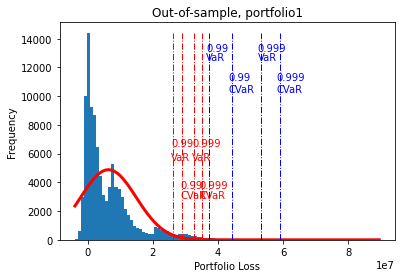

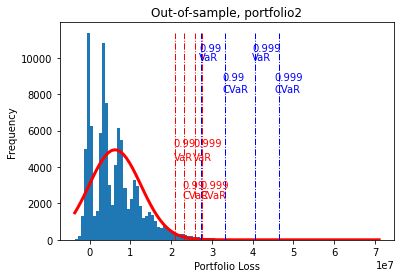

In [ ]:
# Plot results

# out-of-sample scenarios
for portN in range(2):   # 0-1 
  a = Losses_out @ x0[portN] # portfolio loss
  frequencyCounts, binLocations, patches = plt.hist(a, 100)
  normf = (1 / (np.std(a) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(a)) / np.std(a)) ** 2)
  normf = normf * sum(frequencyCounts) / sum(normf)
  plt.plot(binLocations, normf, color='r', linewidth=3.0)

  for q in range(len(alphas)):
    # non-normal
    plt.plot([VaRout[portN,q],  VaRout[portN,q]], [0, max(frequencyCounts)], color='blue', linewidth=1, linestyle='-.')
    plt.text(0.98 * VaRout[portN,q], max(frequencyCounts) / 1.1, alphas[q],color='blue')
    plt.text(0.98 * VaRout[portN,q], max(frequencyCounts) / 1.15, 'VaR',color='blue')

    plt.plot([CVaRout[portN,q],  CVaRout[portN,q]], [0, max(frequencyCounts)], color='blue', linewidth=1, linestyle='-.')
    plt.text(0.98 * CVaRout[portN,q], max(frequencyCounts) / 1.3, alphas[q],color='blue')
    plt.text(0.98 * CVaRout[portN,q], max(frequencyCounts) / 1.4, 'CVaR',color='blue')

    # normal
    plt.plot([VaRinN[portN,q],  VaRinN[portN,q]], [0, max(frequencyCounts)], color='r', linewidth=1, linestyle='-.')
    plt.text(0.98 * VaRinN[portN,q], max(frequencyCounts) / 2.2, alphas[q], color='r')
    plt.text(0.98 * VaRinN[portN,q], max(frequencyCounts) / 2.6, 'VaR', color='r')

    plt.plot([CVaRinN[portN,q],  CVaRinN[portN,q]], [0, max(frequencyCounts)], color='r', linewidth=1, linestyle='-.')
    plt.text(0.98 * CVaRinN[portN,q], max(frequencyCounts) / 4.0, alphas[q],color='r')
    plt.text(0.98 * CVaRinN[portN,q], max(frequencyCounts) / 5.0, 'CVaR',color='r')

  plt.xlabel('Portfolio Loss')
  plt.ylabel('Frequency')
  plt.title('Out-of-sample, portfolio' + str(portN+1))
  plt.show()

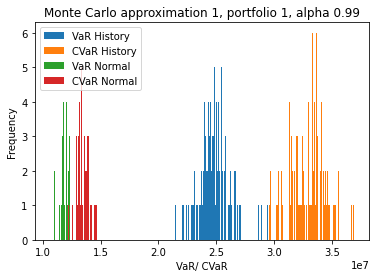

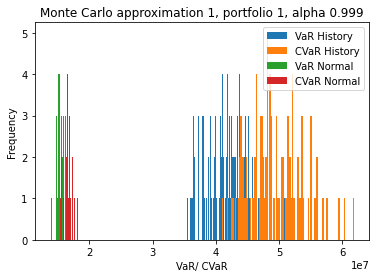

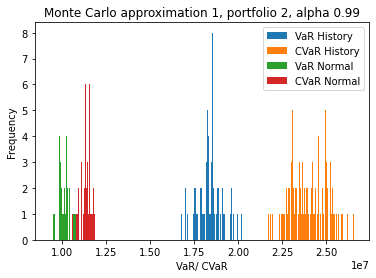

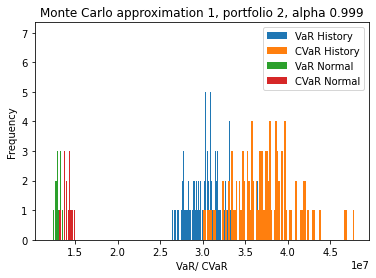

In [ ]:
# Monte Carlo approximation 1
for portN in range(2):   # 0-1 
  for q in range(len(alphas)):
    # Barplot of VaR and CVaR values in those 100 iterations
    frequencyCounts, binLocations, patches = plt.hist(VaRinMC1[portN,q], 100, label='VaR History')
    frequencyCounts, binLocations, patches = plt.hist(CVaRinMC1[portN,q], 100,label='CVaR History')
    frequencyCounts, binLocations, patches = plt.hist(VaRinN1[portN,q], 100,label='VaR Normal')
    frequencyCounts, binLocations, patches = plt.hist(CVaRinN1[portN,q], 100,label='CVaR Normal')

    plt.legend()
    plt.xlabel('VaR/ CVaR')
    plt.ylabel('Frequency')
    plt.title('Monte Carlo approximation 1, portfolio {}, alpha {}'.format(str(portN+1),str(alphas[q])))
    plt.show()
  

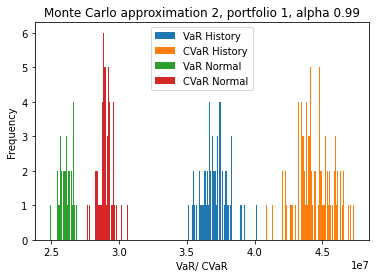

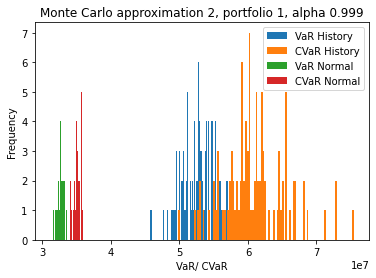

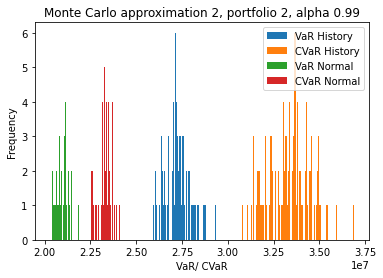

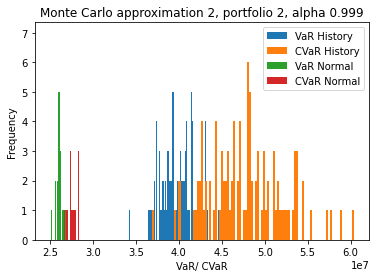

In [ ]:
# Monte Carlo approximation 2

for portN in range(2):   # 0-1 
  for q in range(len(alphas)):
    # Barplot of VaR and CVaR values in those 100 iterations
    frequencyCounts, binLocations, patches = plt.hist(VaRinMC2[portN,q], 100, label='VaR History')
    frequencyCounts, binLocations, patches = plt.hist(CVaRinMC2[portN,q], 100,label='CVaR History')
    frequencyCounts, binLocations, patches = plt.hist(VaRinN2[portN,q], 100,label='VaR Normal')
    frequencyCounts, binLocations, patches = plt.hist(CVaRinN2[portN,q], 100,label='CVaR Normal')

    plt.legend()
    plt.xlabel('VaR/ CVaR')
    plt.ylabel('Frequency')
    plt.title('Monte Carlo approximation 2, portfolio {}, alpha {}'.format(str(portN+1),str(alphas[q])))
    plt.show()